### 목표
- mlp, cnn 모델을 활용하여 개, 고양이 이진 클래스 분류하는 모델을 만들어보자! 
- 모델의 성능을 개선시켜보자!
- 데이터 증식, 기존의 잘 학습된 모델을 사용하는 방법(전이학습)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 이미지 데이터 전처리
- 사진을 데이터화 시키는 작업
- 이미지 -> 배열
- 압축된 형식의 배열로 저장 : npz

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image   # Pillow 라는 라이브러리
from sklearn.model_selection import train_test_split
from zipfile import ZipFile # 압축관련 모듈

In [3]:
%cd /content/drive/MyDrive/colab/DeepLearning_빅데16차
# 경로 바꾸기


/content/drive/MyDrive/colab/DeepLearning_빅데16차


In [ ]:
 #zip파일 압축해제하여 이미지 불러오기
zip_file = './data/cats_and_dogs_filtered.zip'
# 파일 다루는 파이썬 함수 with open(경로, 모드설정)
with ZipFile(zip_file ,'r') as z:
  # 압축파일의 내용 확인하기
  # z.printdir()
  z.extractall(path='./data/')

In [6]:
# 이미지 접근하려면 경로가 필요 ./data/cats_and_dogs_filtered/train/cats/cat.1.jpg

train_cats_dir = './data/cats_and_dogs_filtered/train/cats'
train_dogs_dir = './data/cats_and_dogs_filtered/train/dogs'
test_cats_dir = './data/cats_and_dogs_filtered/test/cats'
test_dogs_dir = './data/cats_and_dogs_filtered/test/dogs'

# os.listdir() : 해당 경로에 있는 파일 명들을 리스트에 순서대로 저장
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
test_cats_fnames = os.listdir(test_cats_dir)
test_dogs_fnames = os.listdir(test_dogs_dir)



In [7]:
print(len(train_cats_fnames))
print(len(train_dogs_fnames))
print(len(test_cats_fnames))
print(len(test_dogs_fnames))


1000
1000
500
500


In [8]:
test_dogs_fnames[ : 5]

# 경로 연결하는 방법
print(test_dogs_dir +'/'+ test_dogs_fnames[0])
print(os.path.join(test_dogs_dir, test_dogs_fnames[0]))

test_path = os.path.join(test_dogs_dir, test_dogs_fnames[0])
test_path

./data/cats_and_dogs_filtered/test/dogs/dog.2000.jpg
./data/cats_and_dogs_filtered/test/dogs/dog.2000.jpg


'./data/cats_and_dogs_filtered/test/dogs/dog.2000.jpg'

In [9]:
# 이미지 한장 불러와서 사이즈 조정 및 배열로 변환
# (224,224)라는 일정한 사이즈로 조정을 해줄꺼임 => 다 다르면 오류가 나니까
img_size = (224,224)
img = Image.open(test_path).resize(img_size)
np.array(img)   # 이미지를 배열로 만들어줌

array([[[ 74, 103,  37],
        [ 81, 110,  44],
        [107, 136,  69],
        ...,
        [146, 151, 119],
        [188, 193, 161],
        [168, 174, 139]],

       [[ 93, 123,  55],
        [ 82, 112,  45],
        [ 84, 114,  46],
        ...,
        [138, 143, 113],
        [186, 191, 160],
        [180, 186, 152]],

       [[116, 147,  75],
        [105, 136,  65],
        [ 95, 126,  56],
        ...,
        [150, 155, 125],
        [217, 222, 190],
        [239, 245, 211]],

       ...,

       [[134, 174,  81],
        [143, 182,  88],
        [134, 174,  79],
        ...,
        [ 98, 142,  55],
        [ 89, 133,  47],
        [ 86, 132,  45]],

       [[171, 213, 124],
        [168, 211, 121],
        [161, 204, 114],
        ...,
        [111, 153,  76],
        [ 93, 135,  59],
        [107, 149,  72]],

       [[179, 222, 133],
        [181, 224, 136],
        [182, 225, 136],
        ...,
        [105, 147,  71],
        [ 95, 137,  61],
        [127, 169,  93]]

In [ ]:
# # 사진을 불러와서 배열로 변경하는 함수 정의
# # 사진 크기는 전부 224 * 224로 고정시켜주기

# def load_images(forder_path,file_names,image_size = (224,224)) :
#   image = []
#   for i in file_names :  # i파일 이름 하나씩 접근
#     # 폴더 경로 + 파일 명 합치기
#     path = os.path.join(forder_path,i)
#     # 파일 오픈, 크기조정
#     img = Image.open(path).resize(image_size)
#     # 배열로 변경, image 빈리스트에 저장
#     image.append(np.array(img))
#   return np.array(image)

In [13]:
# 사진을 불러와서 배열로 변경하는 함수 정의
# 사진 크기는 전부 224,224

def load_images(forder_path, file_names,image_size=(224,224)):
    image = []
    for i in file_names: # i : 파일 이름 하나씩 접근

    # 폴더 경로 + 파일명 합치기
        path = os.path.join(forder_path,i)

    # 파일 오픈, 크기 조정
        img = Image.open(path).resize(image_size)

    # 배열로 변경, image 빈 리스트에 저장
        image.append(np.array(img))
    return np.array(image)

In [14]:
# 함수 호출 -> 4개의 각 폴더에 있는 이미지를 전처리
X_train_cats = load_images(train_cats_dir,train_cats_fnames)
X_train_cats

array([[[[203, 164,  87],
         [205, 166,  89],
         [209, 170,  93],
         ...,
         [245, 204, 119],
         [242, 202, 122],
         [239, 200, 121]],

        [[203, 164,  87],
         [205, 166,  89],
         [209, 170,  93],
         ...,
         [245, 204, 120],
         [242, 203, 122],
         [240, 201, 122]],

        [[203, 164,  87],
         [205, 166,  89],
         [209, 170,  93],
         ...,
         [245, 204, 122],
         [243, 204, 124],
         [241, 202, 123]],

        ...,

        [[154, 123,  56],
         [154, 124,  57],
         [156, 125,  58],
         ...,
         [  3,   3,   1],
         [  3,   3,   1],
         [  3,   3,   1]],

        [[153, 122,  55],
         [153, 122,  55],
         [154, 123,  56],
         ...,
         [  2,   2,   0],
         [  2,   2,   0],
         [  2,   2,   0]],

        [[151, 120,  53],
         [152, 121,  54],
         [153, 122,  55],
         ...,
         [  1,   1,   0],
        

In [15]:
# 함수 호출 -> 4개의 각 폴더의 있는 이미지를 전처리

X_train_dogs = load_images(train_dogs_dir,train_dogs_fnames)
X_test_cats = load_images(test_cats_dir,test_cats_fnames)
X_test_dogs = load_images(test_dogs_dir,test_dogs_fnames)

print(X_train_dogs.shape)
print(X_test_cats.shape)
print(X_test_dogs.shape)



KeyboardInterrupt: ignored

In [16]:
# train끼리 병합 
# test 끼리 병합
# 고양이, 개 순서대로 병합
  
X_train = np.concatenate((X_train_cats,X_train_dogs))  # 1000+1000 
X_test = np.concatenate((X_test_cats,X_test_dogs))  # 500 +500
print(X_train.shape , X_test.shape)

NameError: ignored

In [ ]:
# y_train, y_test
# 고양이 : 0 , 개 : 1
# 정답 데이터 만들기
y_train = np.array([0] * 1000 + [1] *1000) 
y_test = np.array([0]*500 + [1] * 500)

print(y_train.shape , y_test.shape)


In [ ]:
# npz 넘파이 배열 압축 형식으로 데이터 저장
np.savez_compressed('./data/cats_and_dogs.npz' ,
                    X_train = X_train ,   # 훈련 문제
                    X_test = X_test,   # 테스트 문제
                    y_train = y_train,   # 훈련 답
                    y_test = y_test)   # 테스트 답

npz 파일 로딩

In [17]:
data = np.load('./data/cats_and_dogs.npz')
len(data)

4

In [18]:
X_train = data['X_train'] 
y_train = data['y_train']
X_test =  data ['X_test']
y_test =  data['y_test']

print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)


(2000, 224, 224, 3) (2000,)
(1000, 224, 224, 3) (1000,)


### MLP 모델 생성

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
# mlp모델 자유롭게 생성해보기
model_ml = Sequential()

# 입력층(224,224,3)  => Flatten
model_ml.add(Flatten(input_shape = (224,224,3)))

# 중간층
model_ml.add(Dense(200 , activation = 'relu'))
model_ml.add(Dense(100, activation = 'relu'))
model_ml.add(Dense(50 , activation = 'relu'))

# 출력층
# 이진(개,고양이)
model_ml.add(Dense(1, activation = 'sigmoid'))  

model_ml.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 200)               30105800  
                                                                 
 dense_5 (Dense)             (None, 100)               20100     
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,131,001
Trainable params: 30,131,001
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_ml.compile(loss = 'binary_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

# h1 = model_ml.fit(X_train,y_train,validation_split = 0.3 , epochs = 30, batch_size = 64)

In [33]:
# 조기 중단
f_early = EarlyStopping(monitor = 'val_accuracy', patience = 5)

# 학습
h1 = model_ml.fit(X_train,y_train,validation_split = 0.3 , epochs = 30, batch_size = 64, callbacks = [f_early])


Epoch 1/30
22/22 [==============================] - 3s 43ms/step - loss: 3180.0054 - accuracy: 0.6036 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/30
22/22 [==============================] - 1s 25ms/step - loss: 1643.2006 - accuracy: 0.5729 - val_loss: 3226.3394 - val_accuracy: 0.0017
Epoch 3/30
22/22 [==============================] - 0s 21ms/step - loss: 610.0690 - accuracy: 0.6500 - val_loss: 103.7324 - val_accuracy: 0.7283
Epoch 4/30
22/22 [==============================] - 0s 17ms/step - loss: 342.6360 - accuracy: 0.6436 - val_loss: 69.2263 - val_accuracy: 0.7467
Epoch 5/30
22/22 [==============================] - 0s 17ms/step - loss: 696.2123 - accuracy: 0.6093 - val_loss: 2134.7917 - val_accuracy: 0.0000e+00
Epoch 6/30
22/22 [==============================] - 0s 17ms/step - loss: 334.8151 - accuracy: 0.6543 - val_loss: 1369.0316 - val_accuracy: 0.0100


<function matplotlib.pyplot.show(close=None, block=None)>

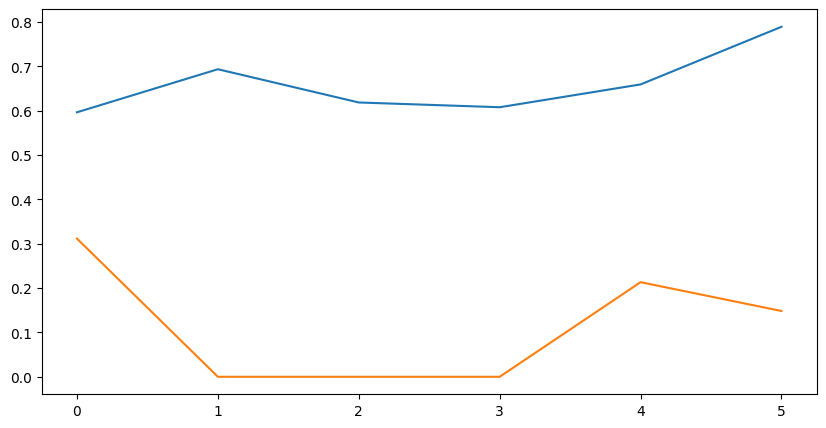

In [ ]:
plt.figure(figsize = (10,5))
plt.plot(h1.history['accuracy'],label = 'acc')
plt.plot(h1.history['val_accuracy'],label = 'val_acc')
plt.legend

plt.show

In [ ]:
# 평가
model_ml.evaluate(X_test,y_test)  # 정확도가 53% 이다. 

32/32 [==============================] - 0s 5ms/step - loss: 58.2124 - accuracy: 0.5310


[58.212440490722656, 0.531000018119812]

#### CNN 모델링

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
# cnn 신경망 구조를 직접 쌓아보기!
model_cnn = Sequential()

# 특성 추출부(convolution)
#  필터, 커널, 마스크 개수 = 32
# 필터 사이즈 = (행,열)
model_cnn.add(Conv2D(32,(3,3),padding = 'same' ,activation = 'relu', input_shape = (224,224,3)))
model_cnn.add(MaxPooling2D(pool_size = 2))

model_cnn.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu' ))
model_cnn.add(MaxPooling2D(pool_size = 2))

model_cnn.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu' ))
model_cnn.add(MaxPooling2D(pool_size = 2))

model_cnn.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu' ))
model_cnn.add(MaxPooling2D(pool_size = 2))

# 분류부(분류하는 층 , mlp)

# 1차원으로 펴주기
model_cnn.add(Flatten())  #  위의 층에서 input_shaep가 있으니까 이게 내려오게 될꺼임


# 중간층 1
model_cnn.add(Dense(512 , activation = 'relu'))

# 출력층
model_cnn.add(Dense( 1 , activation = 'sigmoid'))  # 개 고양이 분류하니까 1개

model_cnn.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 128)     

In [24]:
# 학습/평가 방법 설정
# Adam
model_cnn.compile(loss = 'binary_crossentropy',
                  optimizer = Adam(learning_rate = 0.0001),  # learning_rate 갱신하는 변동폭
                  metrics =['accuracy'])                               # 너무 작으면 도달하는데 힘들까봐


In [26]:
f_early = EarlyStopping(monitor = 'val_accuracy', 
                        patience = 5)

# 훈련 문제, 훈련답, 검증데이터 분리 , 100
h2 = model_cnn.fit(X_train,y_train,validation_split = 0.3, batch_size =64 ,epochs =100,callbacks = [f_early])



Epoch 1/100
22/22 [==============================] - 18s 216ms/step - loss: 10.6289 - accuracy: 0.6043 - val_loss: 0.6741 - val_accuracy: 0.5500
Epoch 2/100
22/22 [==============================] - 2s 100ms/step - loss: 0.6987 - accuracy: 0.6271 - val_loss: 0.8398 - val_accuracy: 0.2817
Epoch 3/100
22/22 [==============================] - 2s 97ms/step - loss: 0.5583 - accuracy: 0.7321 - val_loss: 1.0321 - val_accuracy: 0.1633
Epoch 4/100
22/22 [==============================] - 2s 97ms/step - loss: 0.4859 - accuracy: 0.7786 - val_loss: 1.4817 - val_accuracy: 0.0900
Epoch 5/100
22/22 [==============================] - 2s 101ms/step - loss: 0.4246 - accuracy: 0.8143 - val_loss: 1.3162 - val_accuracy: 0.2217
Epoch 6/100
22/22 [==============================] - 2s 103ms/step - loss: 0.3571 - accuracy: 0.8664 - val_loss: 1.4279 - val_accuracy: 0.2483


<function matplotlib.pyplot.show(close=None, block=None)>

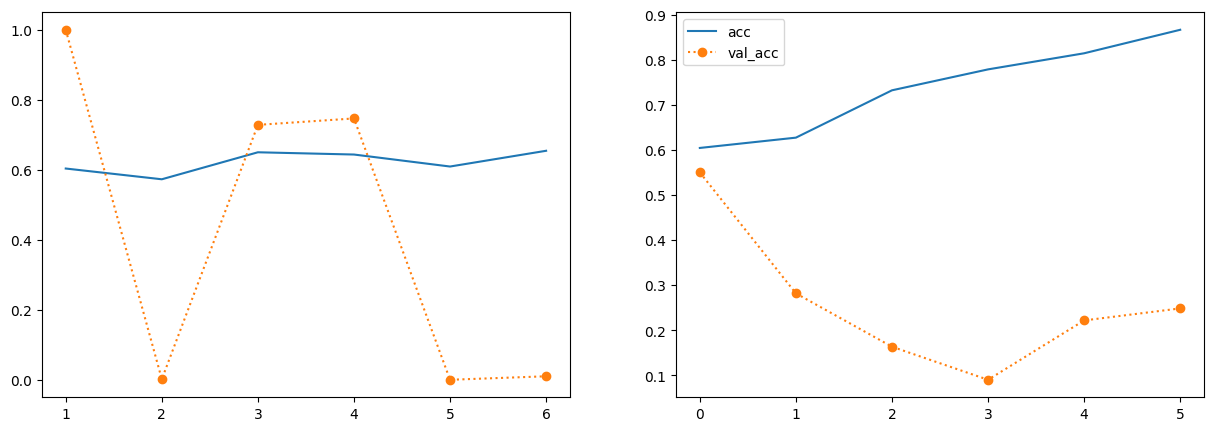

In [38]:
plt.figure(figsize = (15,5))

# acc,val_acc기준으로 시각화
# mlp모델 
plt.subplot( 1,2,1)
x_range = range(1,len(h1.history['accuracy'])+1)
plt.plot(x_range, h1.history['accuracy'],label = 'mlp acc')
plt.plot(x_range, h1.history['val_accuracy'],marker = 'o', ls = ':' ,
         label = 'mlp val_acc')

# cnn모델
plt.subplot( 1,2,2)
plt.plot( h2.history['accuracy'],label = 'cnn acc')
plt.plot(h2.history['val_accuracy'],marker = 'o', ls = ':' ,label = 'cnn val_acc')
plt.legend()
plt.show


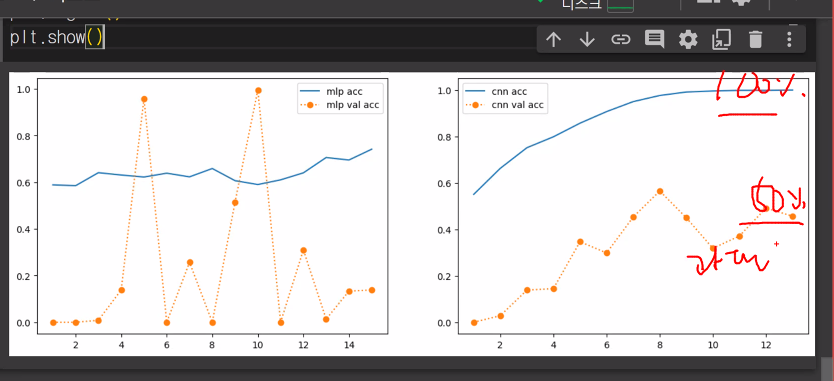

과대적합의 위험성이 있음!
#### 과대적합 방지
- Dropout : 일정한 비율만큼 랜덤으로 중간층의 뉴런을 비활성화, 과도하게 학습되는 현상을 방지함
- Data aumentation(데이터 증식)
  - 데이터 증식을 위해 keras에서 제공하는 이미지 제너레이터를 사용
  - 학습하는 시간은 오래걸리지만 기존보다 과대적이 나름대로 해소됨

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 이미지 증식


In [42]:
# 데이터 확장
# 픽셀값 0 ~ 1 변환
train_gen = ImageDataGenerator(rescale = 1./255,
                               shear_range = 0.15,
                               zoom_range = 0.2, 
                               horizontal_flip = True)

test_gen = ImageDataGenerator(rescale = 1./255)

# 데이터 경로 설정
train_dir = './data/cats_and_dogs_filtered/train'
test_dir = './data/cats_and_dogs_filtered/test'

train_generator = train_gen.flow_from_directory(
    train_dir,  # 폴더 경로
    target_size = (224,224),  # 변환할 이미지의 크기
    batch_size = 10,  # 한번에 변홚라 이미지의 개수
    class_mode = 'binary'   # 라벨 번호는 0부터 시작, 폴더는 알파벳순서로 읽음
)

test_generator = test_gen.flow_from_directory(
    test_dir,  # 폴더 경로
    target_size = (224,224),  # 변환할 이미지의 크기
    batch_size = 10,  # 한번에 변홚라 이미지의 개수
    class_mode = 'binary'   # 라벨 번호는 0부터 시작, 폴더는 알파벳순서로 읽음
)



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [43]:
# 라벨링 결과 확인하기
print(train_generator.class_indices)
print(test_generator.class_indices)

# 고양이는 0 강아지는 1로 인식하겠다!

{'cats': 0, 'dogs': 1}
{'cats': 0, 'dogs': 1}


In [53]:
# 위에서 만든거 가져옴

# cnn 신경망 구조를 직접 쌓아보기!
model_cnn2 = Sequential()

# 특성 추출부(convolution)
#  필터, 커널, 마스크 개수 = 32
# 필터 사이즈 = (행,열)
model_cnn2.add(Conv2D(32,(3,3),padding = 'same' ,activation = 'relu', input_shape = (224,224,3)))
model_cnn2.add(MaxPooling2D(pool_size = 2))

model_cnn2.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu' ))
model_cnn2.add(MaxPooling2D(pool_size = 2))

model_cnn2.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu' ))
model_cnn2.add(MaxPooling2D(pool_size = 2))

model_cnn2.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu' ))
model_cnn2.add(MaxPooling2D(pool_size = 2))

# 분류부(분류하는 층 , mlp)

# 1차원으로 펴주기
model_cnn2.add(Flatten())  #  위의 층에서 input_shaep가 있으니까 이게 내려오게 될꺼임


# 중간층 1
model_cnn2.add(Dense(512 , activation = 'relu'))

# 출력층
model_cnn2.add(Dense( 1 , activation = 'sigmoid'))  # 개 고양이 분류하니까 1개

model_cnn2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 28, 28, 128)     

In [54]:
# 학습/평가 방법 설정 
model_cnn2.compile(loss = 'binary_crossentropy',
                   optimizer = Adam(learning_rate = 0.001),
                   metrics = ['accuracy'])

In [55]:
# 학습
# 이미지 증식을 할 때는 좃기 학습 중단을 사용하지 않음
# 학습 횟수를 늘려줘야함

epochs = 100
h3 = model_cnn2.fit_generator(generator = train_generator, epochs = epochs,
                              validation_data = test_generator)

Epoch 1/100


<ipython-input-55-f34d6ccd304a>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  h3 = model_cnn2.fit_generator(generator = train_generator, epochs = epochs,


200/200 [==============================] - 658s 3s/step - loss: 0.7100 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/100
200/200 [==============================] - 36s 182ms/step - loss: 0.6939 - accuracy: 0.4940 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/100
200/200 [==============================] - 36s 179ms/step - loss: 0.6932 - accuracy: 0.5125 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/100
200/200 [==============================] - 37s 187ms/step - loss: 0.6933 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
200/200 [==============================] - 35s 173ms/step - loss: 0.6932 - accuracy: 0.4880 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/100
200/200 [==============================] - 36s 177ms/step - loss: 0.6942 - accuracy: 0.5065 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/100
200/200 [==============================] - 35s 176ms/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6931 - val_accuracy:

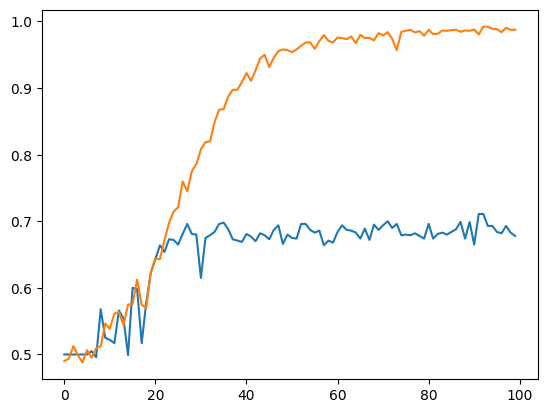

In [57]:
plt.plot(h3.history['val_accuracy'])
plt.plot(h3.history['accuracy'])
plt.show()

In [ ]:
# 기존 CNN 모델로도 약간의 성능을 높였지만 과대적합일 확률이 높음
# 이미지 증식을 통해 cnn 학습 진행 val_acc 향상 70%
# cnn 모델 파라미터 변경해야하는 상황
# 성규씨 256, 0.0001 -> 20번째 val_accuracy 80까지!

#### 전이학습
- 사전에 학습된 모델을 이용하여 개,고양이 분류를 진행해보자
- vgg16모델의 마지막 컨볼루션 층과 mlp층을 미세하게 조정하여 활용해보자(미세조정)

In [59]:
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)


(2000, 224, 224, 3) (2000,)
(1000, 224, 224, 3) (1000,)


In [60]:
from tensorflow.keras.applications import VGG16


In [61]:
vgg16_model = VGG16(include_top = False,
                    weights = 'imagenet',
                    input_shape = (224,224,3))
# include_top = False : 불러온 모델의 mlp층을 사용하지 않겠다.(특징 추출부만 쓰겠다.)
# 최상위 완전 연결층(분류기층)을 포함할 것인지의 여부
#  - 기본값은 ImageNet의 1000개 클래스에 대응하는 완전 연결 분류기를 포함
#  - 개, 고양이만 구분하므로 미포함
#  weigths : ImageNet에서 학습된 가중치(w)를 그대로 가지고 옴
# ImageNet은 1000여개의 클래스로 분류된 100만장의 이미지 데이터셋




58889256/58889256 [==============================] - 3s 0us/step


In [62]:
# 요약 : 다른사람이 만들어둔 요약에 대해서 어떤식으로 쌓아뒀는지 내부를 볼 수 있음
vgg16_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [63]:
# 미세 조정 방식 활용하기
# 층들의 이름 접근해보기
for layer in vgg16_model.layers : 
  print(layer.name)   # conv.pooling층 이름 출력


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [67]:
# 신경망 설계하기

transfer_model = Sequential()

# 미세조정 방식 적용
# --------------------
# vgg16 모델에서 마짐가 몇 개층을 학습이 가능하게 설정
# 그 외 나머지 층들은 학습이 되지 않도록 동결 시켜보자!
for layer in vgg16_model.layers : 
  if layer.name == 'block5_conv3' :
    layer.trainable = True
  else :
    layer.trainable = False
# ------여기까지가 미세조정의 부분!-----
transfer_model.add(vgg16_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(128,activation = 'relu'))
transfer_model.add(Dense(1,activation = 'sigmoid'))
transfer_model.summary()




Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_14 (Dense)            (None, 128)               3211392   
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 17,926,209
Trainable params: 5,571,329
Non-trainable params: 12,354,880
_________________________________________________________________


In [70]:
transfer_model.compile(loss = 'binary_crossentropy',
                       optimizer = Adam(learning_rate = 0.0001),
                       metrics =['accuracy'])

h4 = transfer_model.fit(X_train,y_train,
                   validation_split = 0.3,
                   epochs = 10 )





Epoch 1/10
44/44 [==============================] - 19s 286ms/step - loss: 1.1675 - accuracy: 0.9136 - val_loss: 1.4201 - val_accuracy: 0.8650
Epoch 2/10
44/44 [==============================] - 11s 258ms/step - loss: 0.0463 - accuracy: 0.9886 - val_loss: 0.7236 - val_accuracy: 0.9150
Epoch 3/10
44/44 [==============================] - 9s 199ms/step - loss: 8.0166e-04 - accuracy: 0.9993 - val_loss: 0.6837 - val_accuracy: 0.9217
Epoch 4/10
44/44 [==============================] - 9s 195ms/step - loss: 1.9024e-05 - accuracy: 1.0000 - val_loss: 0.6675 - val_accuracy: 0.9217
Epoch 5/10
44/44 [==============================] - 8s 194ms/step - loss: 9.3408e-06 - accuracy: 1.0000 - val_loss: 0.6786 - val_accuracy: 0.9217
Epoch 6/10
44/44 [==============================] - 8s 190ms/step - loss: 6.8052e-06 - accuracy: 1.0000 - val_loss: 0.6849 - val_accuracy: 0.9200
Epoch 7/10
44/44 [==============================] - 8s 189ms/step - loss: 5.5023e-06 - accuracy: 1.0000 - val_loss: 0.6914 - val_a

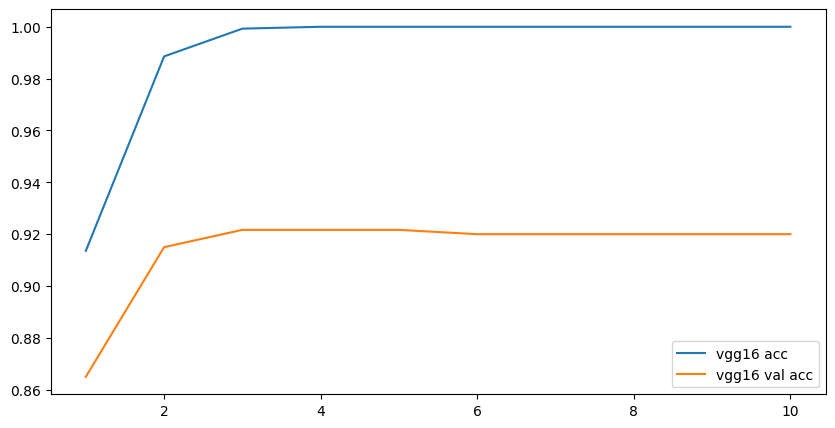

In [74]:
plt.figure(figsize = (10,5))
plt.plot(range(1,len(h4.history['accuracy']) +1), h4.history['accuracy'],label = 'vgg16 acc')
plt.plot(range(1,len(h4.history['val_accuracy']) +1), h4.history['val_accuracy'],label = 'vgg16 val acc')
plt.legend()
plt.show()

In [75]:
# 한번학습이 가능하도록 설정된 층들의 경우 가중치인 w값이 다 바뀌어져서
# 저장되기 때문에 동결층을 추후에 바꾸어주었다면 vgg16모델을 처음으로 import해야 함
# test데이터 평가 마무리
transfer_model.evaluate(X_test,y_test)

32/32 [==============================] - 5s 163ms/step - loss: 0.3591 - accuracy: 0.9630


[0.35905927419662476, 0.9629999995231628]

In [ ]:
6